`# Treinamento de Rede Neural Recorrente para classificação`


## Setup

In [65]:
# Drive
from google.colab import drive

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

# Import `matplotlib` and create a helper function to plot graphs:

In [66]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Retrieving the dataset downloaded from the Google Drive repository

In [67]:
# Conectando ao google drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 avaliacao_da_disciplina_2022_1.xlsx
 bidirectional.png
 bitcoin_wallet_keywords.png
'Colab Notebooks'
 dataset_professora.csv
 dataset_professora.gsheet
 dataset_professora_predicoes.csv
 links_tcc
'Machine learning techniques for emotion detection and sentiment analysis  current state  challenges  and future directions.pdf'
 monero_wallet_keywords.png
 olist_customers_dataset.csv
 olist_preprocessado.csv
 PLN
 RePro.csv
 repro-main.zip
 ReProRnn.csv
 review_repro_preprocessado.csv
 reviews_ptbr.csv
 tcc_analise_sentimento1.xlsx
 tw_pt.csv


# Setup input pipeline
Brazilian E-Commerce Public Dataset by Olist
Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.


In [68]:
df = pd.read_csv("/content/drive/MyDrive/olist_preprocessado.csv")
df.columns

# Vamos fazer um pré-processamento

Index(['Texto', 'Score', 'Label'], dtype='object')

In [69]:
# Removendo comentários que tinham apenas números ou símbolos
df = df[df['Texto'] != '']

In [70]:
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=42)
type(train_dataset)

pandas.core.frame.DataFrame

In [71]:
def dataframe_to_dataset(df):
    # Separa colunas
    texts = df["Texto"].values
    labels = df["Label"].values

    # Converte para tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    return ds

In [72]:
train_dataset = dataframe_to_dataset(train_dataset)
test_dataset = dataframe_to_dataset(test_dataset)

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))



```
# Initially this returns a dataset of (text, label pairs):
```



In [73]:
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'bom'
label:  0
text:  b'n\xc3\xa3o saber ir conseguir ir academia amanh\xc3\xa3 cedo ir arrumar pra ir'
label:  0


# Next shuffle the data for training and create batches of these (text, label) pairs:

In [74]:
# Prepara os dados com shuffle e batching (mas sem aplicar o encoder aqui!)
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [75]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [76]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy())  # Removido o [:3]

texts:  [b'bom dever melhorar qualidade video' b'chato'
 b'bom por\xc3\xa9m bom outro mat\xc3\xa9ria hist\xc3\xb3rio Geografia portugu\xc3\xaas sociologir filosofia arte reda\xc3\xa7\xc3\xa3o ingl\xc3\xaas']

labels:  [0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


# Create the text encoder
The raw text loaded needs to be processed before it can be used in a model.
The simplest way to process text for training is using the TextVectorization layer.
This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [77]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    pad_to_max_tokens=True)
encoder.adapt(train_dataset.map(lambda text, label: text))


# The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [78]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'não', 'app', 'bom', 'aplicativo', 'curso', 'fazer',
       'pra', 'poder', 'ficar', 'dar', 'ter', 'vez', 'aprender', 'todo',
       'aula', 'problema', 'vídeo', 'usar'], dtype='<U15')

# Once the vocabulary is set, the layer can encode text into indices.
The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [79]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  4,  62,  92, 190, 146,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  4,  28,   4,  20, 152, 997, 655,  65,   1,   1,   1,   1,  33,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

# With the default settings, the process is not completely reversible. There are three main reasons for that:

The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [80]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'bom dever melhorar qualidade video'
Round-trip:  bom dever melhorar qualidade video                                               

Original:  b'chato'
Round-trip:  chato                                                   

Original:  b'bom por\xc3\xa9m bom outro mat\xc3\xa9ria hist\xc3\xb3rio Geografia portugu\xc3\xaas sociologir filosofia arte reda\xc3\xa7\xc3\xa3o ingl\xc3\xaas'
Round-trip:  bom porém bom outro matéria histório geografia português [UNK] [UNK] [UNK] [UNK] inglês                                       



## Create the model

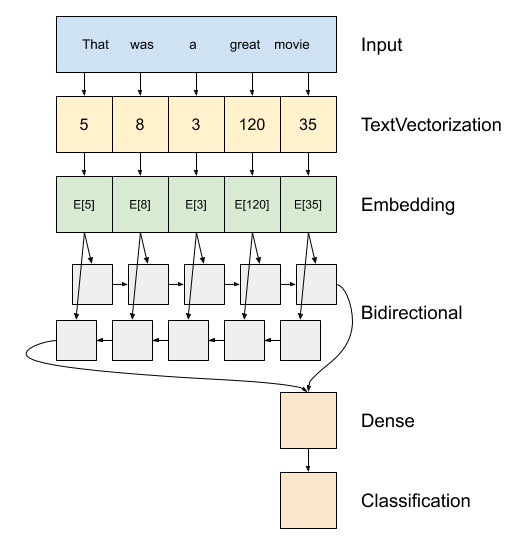

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.

In [47]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [48]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [49]:
# predict on a sample text without padding.

sample_text = ('O filme foi ótimo')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.00499696]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [50]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
[-0.00499696]


Compile the Keras model to configure the training process:

In [51]:
# Compila o modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [52]:
# Treina o modelo
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6606 - loss: 0.6839

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.6605 - loss: 0.6838 - val_accuracy: 0.6871 - val_loss: 0.6197
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.6611 - loss: 0.6210 - val_accuracy: 0.6871 - val_loss: 0.5762
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.6575 - loss: 0.5733 - val_accuracy: 0.6871 - val_loss: 0.5092
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.6493 - loss: 0.5165 - val_accuracy: 0.7377 - val_loss: 0.4730
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7528 - loss: 0.4646 - val_accuracy: 0.7940 - val_loss: 0.4593
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.8022 - loss: 0.4238 - val_accuracy: 0.8033 - val_loss: 0.4579
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.8224 - loss: 0.3981 - val_accuracy: 0.7997 - val_loss: 0.4675
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.8330 - loss: 0.3842 - val_accuracy: 0.807

In [53]:
# Avalia o modelo
test_loss, test_acc = model.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8046 - loss: 0.4644


In [54]:
print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_acc)


Test Loss: 0.4774121344089508
Test Accuracy: 0.7990021109580994


Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [59]:
def interpretar_sentimento(pred):
    if pred >= 0.0:
        return "Sentimento Positivo"
    else:
        return "Sentimento Negativo"

In [64]:
sample_text = ('A aula deixou a desejar')
predictions = model.predict(tf.constant([sample_text]))
print(interpretar_sentimento(predictions[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Sentimento Negativo


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

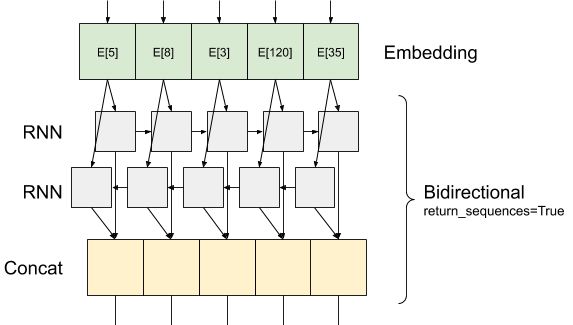

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [81]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [82]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [83]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 242ms/step - accuracy: 0.6498 - loss: 0.6860 - val_accuracy: 0.6871 - val_loss: 0.6215
Epoch 2/10
 1/88 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.5469 - loss: 0.6843

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.6504 - loss: 0.6276 - val_accuracy: 0.6871 - val_loss: 0.5785
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - accuracy: 0.6489 - loss: 0.5866 - val_accuracy: 0.6871 - val_loss: 0.5084
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.6425 - loss: 0.5222 - val_accuracy: 0.7234 - val_loss: 0.4800
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 0.7203 - loss: 0.4737 - val_accuracy: 0.7584 - val_loss: 0.4648
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 0.7734 - loss: 0.4278 - val_accuracy: 0.7755 - val_loss: 0.4646
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 234ms/step - accuracy: 0.7900 - loss: 0.4045 - val_accuracy: 0.7790 - val_loss: 0.4719
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.8061 - loss: 0.3830 - val_accuracy: 0.7840 - val_loss: 0.4796
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.8114 - loss: 0.3747 - val_accuracy: 0.786

In [84]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7862 - loss: 0.4816
Test Loss: 0.49662676453590393
Test Accuracy: 0.7883107662200928


In [86]:
# predict on a sample text without padding.

sample_text = ('Gostei do curso mas deixou a desejar em alguns aspectos')
predictions = model.predict(tf.constant([sample_text]))
print(interpretar_sentimento(predictions[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Sentimento Negativo


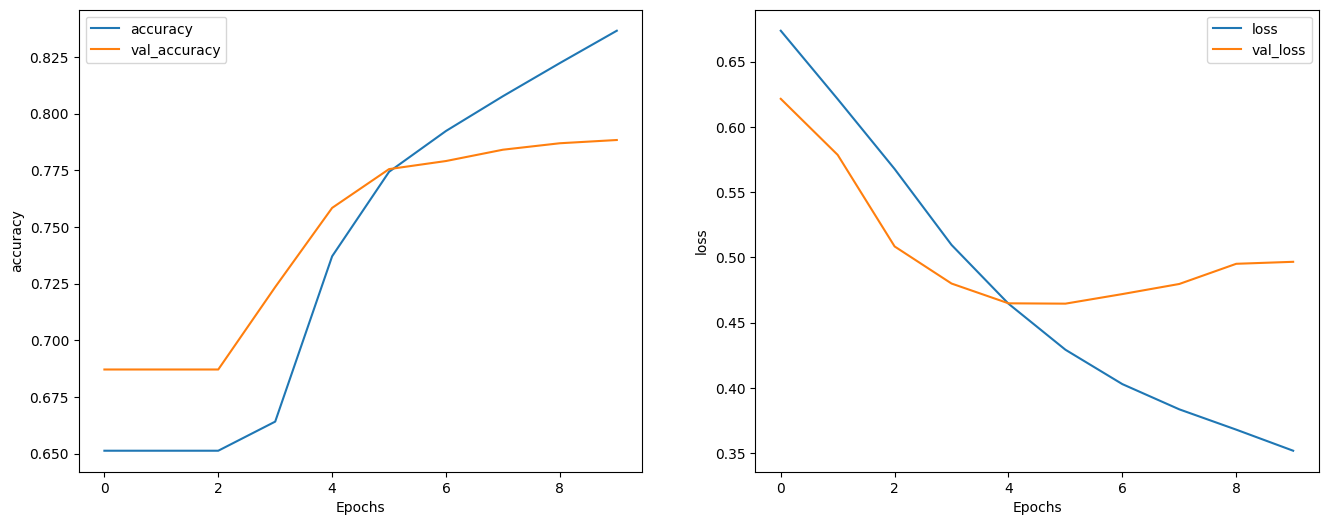

In [87]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')